# Simple Univariate Projection

First map Google drive.

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


Load the three data files.

In [ ]:
import pandas as pd
import os

PATH = "/content/drive/MyDrive/projects/demand/"

df_sales = pd.read_csv("https://data.heatonresearch.com/wustl/CABI/demand-forecast/sales_train.csv", parse_dates=['date'])
df_items = pd.read_csv("https://data.heatonresearch.com/wustl/CABI/demand-forecast/items.csv")
df_resturant = pd.read_csv("https://data.heatonresearch.com/wustl/CABI/demand-forecast/resturants.csv")

Utility function to create sequences.

In [ ]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Join the items and sales tables so that we can look up the store id for each item.

In [ ]:
df_items2 = df_items[['id','store_id']]
df_train = df_sales.merge(df_items2,left_on='item_id',right_on='id')
df_train[['date','item_id','item_count','store_id']]

df_train = df_train.sort_values('date').groupby(['item_id', 'store_id', 'date'], as_index=False)
df_train = df_train.agg({'item_count':['mean']})
df_train.columns = ['item', 'store', 'date', 'sales']
df_train.head()

,item,store,date,sales
0,1,4,2020-12-01,1.0
1,1,4,2021-10-14,1.0
2,2,4,2020-04-30,1.0
3,2,4,2020-06-09,1.0
4,2,4,2020-12-26,1.0


Build the sequence data.

In [ ]:
window = 29
future_span = 30
series = series_to_supervised(df_train.drop('date', axis=1), window=window, lag=future_span)
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+30),store(t+30),sales(t+30)
29,1.0,4.0,1.0,1.0,4.0,1.0,2.0,4.0,1.0,2.0,...,2.0,3.0,1.0,2.0,3,1,3.0,3.0,1.0,3.0
30,1.0,4.0,1.0,2.0,4.0,1.0,2.0,4.0,1.0,2.0,...,2.0,3.0,1.0,3.0,3,1,1.0,3.0,1.0,1.0
31,2.0,4.0,1.0,2.0,4.0,1.0,2.0,4.0,1.0,2.0,...,3.0,3.0,1.0,1.0,3,1,1.0,3.0,1.0,2.0
32,2.0,4.0,1.0,2.0,4.0,1.0,2.0,4.0,1.0,3.0,...,1.0,3.0,1.0,1.0,3,1,2.0,3.0,1.0,1.0
33,2.0,4.0,1.0,2.0,4.0,1.0,3.0,1.0,4.0,3.0,...,1.0,3.0,1.0,2.0,3,1,1.0,3.0,1.0,1.0


Remove sequences that did not have enough data.

In [ ]:
# Remove edge cases, where there were not enough values to complete a series
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

We will just predict using the sales column.

In [ ]:
# Remove all but the sales column
columns_to_drop = [('%s(t+%d)' % (col, future_span)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

Extract the predictors (x sequences) and the label (future prediction)

In [ ]:
from sklearn.model_selection import train_test_split

# Label
labels_col = 'sales(t+%d)' % future_span
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (8287, 30)
Validation set shape (5526, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
4894,20.0,10.0,12.0,12.0,16.0,10.0,19.0,21.0,12.0,6.0,...,19.0,18.0,10.0,16.0,16.0,22.0,20.0,22.0,19.0,12.0
3204,8.0,9.0,9.0,13.0,16.0,13.0,2.0,8.0,5.0,9.0,...,5.0,2.0,4.0,7.0,15.0,18.0,12.0,3.0,7.0,10.0
7790,38.0,57.0,72.0,64.0,75.0,37.0,28.0,35.0,53.0,45.0,...,21.0,34.0,39.0,71.0,73.0,55.0,27.0,30.0,34.0,40.0
4236,192.0,181.0,177.0,213.0,247.0,301.0,293.0,166.0,227.0,207.0,...,289.0,152.0,180.0,201.0,190.0,268.0,294.0,299.0,176.0,155.0
5074,16.0,15.0,16.0,3.0,10.0,8.0,8.0,14.0,18.0,20.0,...,12.0,19.0,10.0,14.0,10.0,9.0,8.0,4.0,15.0,11.0


Final preparation for the x and y.

In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (8287, 30, 1)
Validation set shape (5526, 30, 1)


Construct the neural network.

In [ ]:
import tensorflow as tf 
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout
import keras

epochs = 500 
batch = 256
lr = 0.0003
adam = tf.keras.optimizers.Adam(lr)

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=8, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 23, 64)            576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 11, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 704)               0         
                                                                 
 dense (Dense)               (None, 50)                35250     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                        

Fit the neural network.

In [ ]:
from keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, 
        verbose=1, mode='auto', restore_best_weights=True)

cnn_history = model_cnn.fit(X_train_series, Y_train, callbacks=[monitor],
    validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/500
259/259 - 4s - loss: 534.3746 - val_loss: 243.1342 - 4s/epoch - 17ms/step
Epoch 2/500
259/259 - 1s - loss: 325.4191 - val_loss: 223.7078 - 771ms/epoch - 3ms/step
Epoch 3/500
259/259 - 1s - loss: 310.7113 - val_loss: 223.1814 - 767ms/epoch - 3ms/step
Epoch 4/500
259/259 - 1s - loss: 295.9442 - val_loss: 199.8398 - 752ms/epoch - 3ms/step
Epoch 5/500
259/259 - 1s - loss: 288.7663 - val_loss: 198.0298 - 764ms/epoch - 3ms/step
Epoch 6/500
259/259 - 1s - loss: 280.0478 - val_loss: 181.2358 - 772ms/epoch - 3ms/step
Epoch 7/500
259/259 - 1s - loss: 259.7377 - val_loss: 188.6393 - 758ms/epoch - 3ms/step
Epoch 8/500
259/259 - 1s - loss: 257.7482 - val_loss: 169.3279 - 753ms/epoch - 3ms/step
Epoch 9/500
259/259 - 1s - loss: 255.9915 - val_loss: 169.6519 - 774ms/epoch - 3ms/step
Epoch 10/500
259/259 - 1s - loss: 250.1288 - val_loss: 169.8029 - 761ms/epoch - 3ms/step
Epoch 11/500
259/259 - 1s - loss: 255.9437 - val_loss: 163.6035 - 760ms/epoch - 3ms/step
Epoch 12/500
259/259 - 1s - loss

Predict and evaluate the validation data.

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

Train rmse: 9.176975122603912
Validation rmse: 9.770104572641024


Plot the training curve.

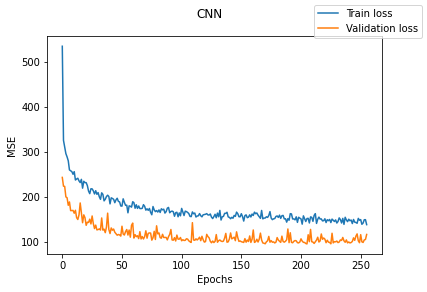

In [ ]:
import matplotlib.pyplot as plt

#fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
#ax1, ax2 = axes[0]
#ax3, ax4 = axes[1]

fig = plt.figure()
plt.plot(cnn_history.history['loss'], label='Train loss')
plt.plot(cnn_history.history['val_loss'], label='Validation loss')
fig.legend()
fig.suptitle('CNN')
plt.xlabel("Epochs")
plt.ylabel("MSE")

plt.show()